<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main()</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [18]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
list(map(lambda x:sys.path.append(x), confParser['input files']['lib_path'].split()))
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net', 'ml mc']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [15]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            if irun == 0:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz .'%(path,irun))
            try:
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()
        
    def Combine(self):
        
        if self.verbose:
            print('concatenating descriptors ...')
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
        descriptors_center_atoms = self.descriptors[atom_ids]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def SklearnMLP(self,X_train,y_train):
        #-----------------------
        #--- parameter grid
        #-----------------------
#         param_grid = {
#                         'hidden_layer_sizes':self.hidden_layer_sizes,
#                          #'activation' : ['tanh', 'relu'],
#                          'learning_rate_init':self.learning_rate_init,
# #                         'alpha':self.alpha, #--- regularization 
#                          #'learning_rate' : ['invscaling', 'adaptive'],
#                         'n_iter_no_change':self.n_iter_no_change,
# #                        'tol':self.tol,
#                         'max_iter':self.max_iter,
#                      } 
        mlp   =  MLPClassifier(random_state=1,
                               hidden_layer_sizes = self.hidden_layer_sizes[0],
                               learning_rate_init = self.learning_rate_init[0],
                               n_iter_no_change   = self.n_iter_no_change[0],
                               max_iter           = self.max_iter[0],
                               verbose=self.verbose)
#         clf  =  GridSearchCV(mlp, param_grid)
#        clf.fit(X_train,y_train)
        mlp.fit(X_train,y_train)
        model =  mlp #clf.best_estimator_
        loss  =  model.loss_curve_
        val_loss = loss
        return (model, loss, val_loss)

    def KerasANN(self, X_train, y_train,X_test, y_test, ndime):

        model     = keras.Sequential([ #--- The network architecture
                                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                #                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                                    layers.Dense(ndime, activation='softmax')
                                    ])
        
#         shape         =  (self.shape[0]*self.shape[1]*self.shape[2],)
#         inputs        =  keras.Input(shape=shape)
#         #------------------------------
#         #--- The network architecture
#         #------------------------------
#         x             =  layers.Dense(   self.hidden_layer_size, activation=self.activation
#                                        )(inputs)
#         for i in range( self.number_hidden_layers ):
#             x       = layers.Dense( self.hidden_layer_size, activation=self.activation
#                                      )(x)
#         #--- output layer
# #         x       = layers.Flatten()(x)
#         outputs = layers.Dense( ndime, activation=self.activation)(x)
#         model   = keras.Model(inputs=inputs, outputs=outputs)

        
        
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate_init) #--- compilation step
        model.compile( optimizer=optimizer,
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"]
                     )
        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
                                                    monitor="mse",
                                                    save_freq=10,
                                                    save_best_only=True)]

        model.fit( X_train, y_train, 
           validation_data      = ( X_test, y_test ),
            callbacks           = callbacks,
            epochs              = self.max_iter[0], 
            verbose             = self.verbose, 
            shuffle             = False, 
#             batch_size     = 32,
#                     use_multiprocessing = True,
#                     workers             = 4,
         )        
        loss      = model.history.history['loss']
        val_loss  = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        return (best_model, loss, val_loss)
                             
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        
#         pdb.set_trace()

        ndime = 2 #--- binary classification
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )

        #--- train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                (model, loss, val_loss) = self.SklearnMLP(X_train,y_train)
                classes_x = model.predict(X_test) 
                
            elif self.implementation == 'keras': #--- dense nn in keras
                (model, loss, val_loss) = self.KerasANN(X_train, y_train,X_test, y_test, ndime)
                predict_x = model.predict(X_test) 
                classes_x = np.argmax(predict_x,axis=1)
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetworkClassifier( y )
            predict_x = model.predict(X_test) 
            classes_x = np.argmax(predict_x,axis=1)
                    
        #--- save loss data
        !mkdir png
        np.savetxt('png/val_loss_classification.txt',
                   np.c_[range(len(loss)),loss,val_loss],
                   header='epoch loss val_loss')

        #--- confusion matrix
        cm = confusion_matrix(y_test, classes_x,
                         labels=[0, 1]
                        )
        np.savetxt('png/confusion.txt',np.c_[cm])

        

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)


        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                #-----------------------
                #--- parameter grid
                #-----------------------
                param_grid = {
                                'hidden_layer_sizes':self.hidden_layer_sizes,
                                 #'activation' : ['tanh', 'relu'],
                                 'learning_rate_init':self.learning_rate_init,
                                'alpha':self.alpha, #--- regularization 
                                 #'learning_rate' : ['invscaling', 'adaptive'],
                                'n_iter_no_change':self.n_iter_no_change,
                                'tol':self.tol,
                                'max_iter':self.max_iter,
                             } 
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                    layers.Dense(ndime, activation=self.activation)
                    ])
                optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose)#, batch_size=128)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetwork(X_train, y_train, X_test, y_test )
            

        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        #--- plot predictions
        y_pred       = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
            utl.PltErr(y_test[:,idime],y_pred[:,idime],
                       attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
        
        #--- save in ovito
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('test.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_test,y_pred],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
                                                   monitor="loss",
                                                  save_freq=10,
                                                    save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step
        model.compile( optimizer =  optimizer,
                       loss="binary_crossentropy",#"sparse_categorical_crossentropy",
                       metrics   =  ["accuracy"]
                     )

        #--- save best model
        !mkdir best_model
        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
                                                    monitor="accuracy",
                                                    save_freq=10,
                                                    save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    
    def PrintDensityMap(self, atomIndx, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData.iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.positions.T,self.descriptors[atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())
#     def SaveConf(self,fout):
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[self.perAtomData],header=' '.join(list(self.perAtomData.keys())))

#     def Test(self,y,
#                                    random_state=1
#                                    ):
#             '''
#             Convolutional neural network.

#             Parameters
#             ----------
#             X_train : array-like training x input

#             y_train : array-like, training y input

#             X_test : array-like test x input

#             y_test : array-like, training y input

#             Return
#             ---------- ( , loss,  )
#             best_model : cnn object, best trained model based on on the validation loss

#             loss : array-like, mse loss

#             val_loss : array-like, validation loss

#             '''

#             if self.verbose:
#                 print('dim(y)=',y.shape)

#             ndime  = y.shape[1] #--- dimension of the target vector


#             #---------------
#             #--- zscore X
#             #---------------        
#             X      = np.c_[self.descriptors ]
#             scaler = StandardScaler()
#             scaler.fit(X)
#             X      = scaler.transform( X )

#             if self.verbose:
#                 print('X.shape:=',X.shape)



#             #-----------------------
#             #--- train-test split
#             #-----------------------
#             X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                                 random_state=random_state)



#             #---- set model parameters
#             shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
#             kernel_size   =  self.kernel_size 
#             epochs        =  self.max_iter[0]
#             activation    =  self.activation
#             padding       = 'same'
#             filters       =  self.n_channels
#             learning_rate = self.learning_rate_init[0]
#             #
#             ndime         =  y_train.shape[1]
#             n_train       =  X_train.shape[0]
#             n_test        =  X_test.shape[0]
#             assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
#             inputs        =  keras.Input(shape=shape)
#             #
#     #         pdb.set_trace()
#             #------------------------------
#             #--- The network architecture
#             #------------------------------
#             model     = keras.Sequential([
#                 layers.Dense(self.hidden_layer_size, activation="relu"),
#     #             layers.Dense(self.hidden_layer_size), #activation="relu"),
#                 layers.Dense(2, activation="softmax")
#                 ])
#             optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

#             model.compile( optimizer="rmsprop",
#                            loss="sparse_categorical_crossentropy",
#                            metrics=["mse"])


#             #--- “Fitting” the model X_train_transfrmd, y_train
#             X_train_reshaped =  X_train 
#             X_test_reshaped  =  X_test
#             model.fit( X_train_reshaped, y_train, 
#                        validation_data      = ( X_test_reshaped, y_test ),
#     #                     callbacks=callbacks,
#                         epochs              = epochs, 
#                         verbose             = self.verbose, 
#                         shuffle             = False, 
#     #                     batch_size     = 128,
#                         use_multiprocessing = True,
#                         workers             = 4,
#                      )        


#             #--- save best model
#             !mkdir best_model
#     #         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#     #                                                    monitor="val_loss",
#     #                                                   save_freq=10,
#     #                                                     save_best_only=True)]


#             #--- validation loss
#             loss       = model.history.history['loss']
#             val_loss   = model.history.history['val_loss']
#             best_model = model #keras.models.load_model("best_model/convnet_from_scratch.tf")


#             !mkdir png
#             utl.PltErr(range(len(loss)), loss,
#                        yscale='log',
#                        xstr='epoch',ystr='loss',
#                        title='png/loss_classification.png',
#                       )

#     #         pdb.set_trace()
#             #--- confusion matrix
#             cm = confusion_matrix(y_test, model.predict_classes(X_test),
#                              labels=[0, 1]
#                             )
#             print('cm=',cm)
#             np.savetxt('png/confusion.txt',np.c_[cm])


In [16]:
dir(NeuralNetwork)

['Combine',
 'ConvNetwork',
 'ConvNetworkClassifier',
 'GetCenterAtom',
 'KerasANN',
 'PCA',
 'Parse',
 'PrintDensityMap',
 'SklearnMLP',
 'Spectra',
 'TrainClassifier',
 'TrainRegressor',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'zscore']

## main()

In [13]:
 def main():
 
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
                        n_iter_no_change   = eval(confParser['neural net']['n_iter_no_change']),
                        tol                = eval(confParser['neural net']['tol']),
                        max_iter           = eval(confParser['neural net']['max_iter']),
                        alpha              = eval(confParser['neural net']['alpha']),
                        hidden_layer_size  = eval(confParser['neural net']['hidden_layer_size']),
                        fully_connected    = eval(confParser['neural net']['fully_connected']),
                        implementation     = eval(confParser['neural net']['implementation']),
                        cnn                = eval(confParser['neural net']['cnn']),
                        n_channels         = eval(confParser['neural net']['n_channels']),
                        kernel_size        = eval(confParser['neural net']['kernel_size']),
                        activation         = eval(confParser['neural net']['activation']),
                        number_hidden_layers = eval(confParser['neural net']['number_hidden_layers']),
                        verbose            = True 
                    )
    
    nn.Parse( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net']['nruns']))

    nn.Combine() #--- concat. descriptors
    
#     tmp = nn.df_combined.set_index('id')
#    display(nn.perAtomData.iloc[:13])
#    nn.PrintDensityMap(6,'density6.xyz')
#    nn.PCA()
#    nn.Spectra()


    #--- classifier
    if eval(confParser['neural net']['classification']):
        nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
#        nn.Test(np.c_[nn.perAtomData.defect_label].astype(int))
    
    
    #--- filter data
    train_type = int(eval(confParser['neural net']['train_type']))
    
    filtr      = {
                     0: nn.perAtomData.defect_label == 1.0, #--- only non-crystalline atoms
                     1: np.ones(len(nn.perAtomData),dtype=bool), #--- every atom
                    }[train_type]
    stratify   = {
                    0:None,
                    1:np.c_[nn.perAtomData.defect_label].astype(int), #--- ensure same ratio in test and training
                    }[train_type]


    
    #--- train regressor
    if eval(confParser['neural net']['regression']):

        nn.TrainRegressor(  stratify=stratify,
                            y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                            printOvito = True,
                            filtr=filtr,
                         )
    return nn

!rm -r png;mkdir png
data = main()

concatenating descriptors ...
mkdir: best_model: File exists
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/32 [..............................] - ETA: 17s - loss: 0.6944 - mse: 0.2522WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x7f9608e6d050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


10/32 [========>.....................] - ETA: 1s - loss: 0.7395 - mse: 0.2605 WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x7f9606cbf9e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


20/32 [=================>............] - ETA: 0s - loss: 0.7222 - mse: 0.2586WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9605f499e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 2s 58ms/step - loss: 0.7519 - mse: 0.2591 - val_loss: 0.7847 - val_mse: 0.2572
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.7194 - mse: 0.2589 - val_loss: 0.7566 - val_mse: 0.2572
Epoch 3/10
11/32 [=========>....................] - ETA: 0s - loss: 0.6611 - mse: 0.2600WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x7f9605f5a200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poson

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


INFO:tensorflow:Assets written to: best_model/convnetClassifier_from_scratch.tf/assets


32/32 [==============================] - 1s 44ms/step - loss: 0.6924 - mse: 0.2587 - val_loss: 0.7280 - val_mse: 0.2573
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.6676 - mse: 0.2592 - val_loss: 0.6977 - val_mse: 0.2577
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6425 - mse: 0.2597 - val_loss: 0.6652 - val_mse: 0.2583
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.6177 - mse: 0.2604 - val_loss: 0.6335 - val_mse: 0.2592
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.5936 - mse: 0.2612 - val_loss: 0.6014 - val_mse: 0.2602
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.5702 - mse: 0.2623 - val_loss: 0.5685 - val_mse: 0.2614
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.5476 - mse: 0.2636 - val_loss: 0.5400 - val_mse: 0.2623
Epoch 10/10
32/32 [==============================] - 0s 9ms/step - loss: 0.5257 - mse: 0.2652 - va

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - 0s 2ms/step
mkdir: png: File exists


### Plot

[[279.  61.]
 [  1.   1.]]


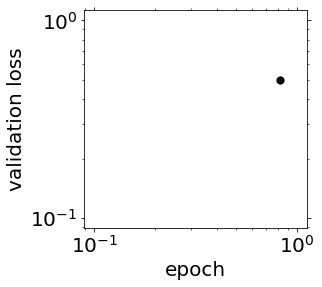

In [14]:
legend = utl.Legends()
legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
symbols = utl.Symbols()

fp = ['confusion.txt', 'val_loss_classification.txt'][0]
data = np.loadtxt('png/%s'%(fp))
ax = utl.PltErr(None, None, Plot=False )
if fp == 'confusion.txt':
    accuracy_crystals = data[0,0]/np.sum(data[0,:])
    accuracy_defects = data[1,1]/np.sum(data[1,:])
    print(data)
    utl.PltErr(accuracy_crystals, accuracy_defects,
       attrs=symbols.GetAttrs(count=0,nevery=800,
            ), 
               Plot=False,
               ax=ax,
               )
else:
    epoch = data[:,0]
    loss = data[:,1]
    val_loss = data[:,2]

    utl.PltErr(epoch, val_loss,
       attrs=symbols.GetAttrs(count=0,nevery=10,
            ), 
               Plot=False,
               ax=ax,
               )
    
ax = utl.PltErr(None, None,
yscale='log',xscale='log',
xstr='epoch',ystr='validation loss',
#                     ylim=(1e-1,1e1),
ax=ax,
# legend=legend.Get(),
title='png/training_loss.png',
)

[[323.  17.]
 [  1.   2.]]
[[322.  18.]
 [  1.   2.]]
[[327.  13.]
 [  0.   3.]]


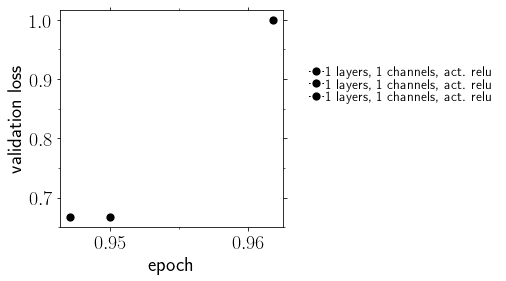

In [20]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    

    
    #--- ann
    number_hidden_layers  = dict(zip(range(4),[1]))
    hidden_layer_size     = dict(zip(range(4),[1]))
    n_channels            = dict(zip(range(4),[1]))
    activations           = dict(zip(range(20),['relu']))
#     string[ inums ] = "\t\'5\':\'neuralNet/20x20/ann/classifier/layer%s/channel%s/activation%s/layer_size%s\',\n" % (key_n,key_c,key_a,key_h) #--- change job name
    
    #--- cnn
#     number_hidden_layers  = dict(zip(range(4),[1,2,3]))
#     hidden_layer_size     = dict(zip(range(4),[1]))
#     n_channels            = dict(zip(range(4),[8,16,32,64]))
#     activations           = dict(zip(range(20),['linear']))

    runs = [0,1,2]
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
#         if number_hidden_layer != 2:
#             continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 16:
#                 continue
            for key_a in activations:
                activation = activations[key_a]
                for key_h in hidden_layer_size:
                    nsize = hidden_layer_size[key_h]

        #---	
#                    path = 'neuralNet/20x20/cnn/classifier/layer%s/channel%s/activation%s/layer_size%s'%(key_n,key_c,key_a,key_h) #--- change job name
                    path = 'test' #--- change job name
                    fp = ['confusion.txt', 'val_loss_classification.txt'][0]
                    for irun in runs:
                        try:
                            data = np.loadtxt('%s/Run%s/png/%s'%(path,irun,fp))
                        except:
                            continue

                        if fp == 'confusion.txt':
                            accuracy_crystals = data[0,0]/np.sum(data[0,:])
                            accuracy_defects = data[1,1]/np.sum(data[1,:])
                            print(data)
                            utl.PltErr(accuracy_crystals, accuracy_defects,
                               attrs=symbols.GetAttrs(count=count%7,nevery=800,
                                    label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                        else:
                            epoch = data[:,0]
                            loss = data[:,1]
                            val_loss = data[:,2]

                            utl.PltErr(epoch, val_loss,
                               attrs=symbols.GetAttrs(count=count%7,nevery=800,
                                    label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                    count += 1
    ax = utl.PltErr(None, None,
#                         yscale='log',xscale='log',
                       xstr='epoch',ystr='validation loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

## test example: 2d

In [17]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

[[1.725966 1.725967]]
(3, 441)


### fully connected in sklearn

Iteration 1, loss = 1.79024675
Iteration 2, loss = 4.79153813
Iteration 3, loss = 0.48272480
Iteration 4, loss = 0.84242732
Iteration 5, loss = 1.20200108
Iteration 6, loss = 0.50029766
Iteration 7, loss = 0.08083888
Iteration 8, loss = 0.31471365
Iteration 9, loss = 0.39602049
Iteration 10, loss = 0.14417737
Iteration 11, loss = 0.05911270
Iteration 12, loss = 0.17784119
Iteration 13, loss = 0.18843745
Iteration 14, loss = 0.08671426
Iteration 15, loss = 0.05304450
Iteration 16, loss = 0.09624741
Iteration 17, loss = 0.09671026
Iteration 18, loss = 0.05631733
Iteration 19, loss = 0.05017827
Iteration 20, loss = 0.06458879
Iteration 21, loss = 0.05694448
Iteration 22, loss = 0.04181389
Iteration 23, loss = 0.04398522
Iteration 24, loss = 0.04448364
Iteration 25, loss = 0.03786413
Iteration 26, loss = 0.03483561
Iteration 27, loss = 0.03725800
Iteration 28, loss = 0.03546887
Iteration 29, loss = 0.03089711
Iteration 30, loss = 0.03086940
Iteration 31, loss = 0.03225031
Iteration 32, los

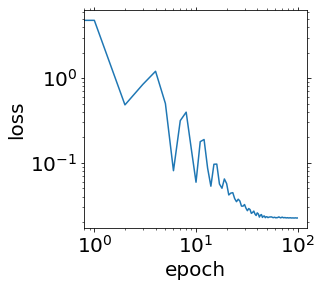

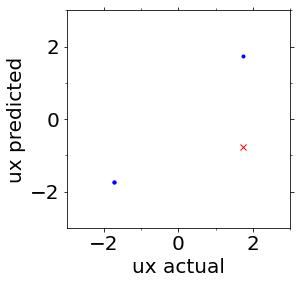

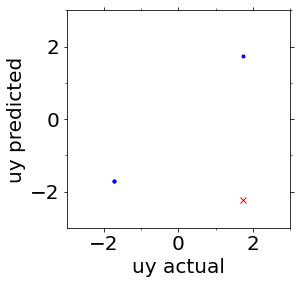

In [20]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
#                     verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=100,#00,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [ ]:
# mlp.best_loss_, mlp.loss_

In [ ]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# ux,uy

In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [ ]:
# data.Spectra(nrows=100)

In [ ]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [ ]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [ ]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [ ]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [ ]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# (ux,uy), y_test[0]